In [90]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import csv
import cv2
import scipy.stats as stats
import scipy
import pickle
import pandas
from pandas import read_csv
import pandas as pd
import glob

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle as shuffle

In [91]:
%matplotlib inline

In [3]:
# Load a pickle file
def load_pickle(file_path):
    with open(file_path, mode='rb') as f:
        file_data = pickle.load(f)
        return file_data;


# Create a pickle
def create_pickle(file_path, data):
    pickle.dump(data, open(file_path, "wb"))
    print("Data saved in", file_path)

In [4]:
def diaply_images(rows,cols,images,labels):
    gs1 = gridspec.GridSpec(rows,cols)
    gs1.update(wspace=0.01, hspace=0.02)
    plt.figure(figsize=(12,8))
    for i in range(rows * cols):
        ax1 = plt.subplot(gs1[i])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        rnd_idx = np.random.choice(len(images))
        plt.text(2,5,
                 str(labels[rnd_idx]),
                 color='k',
                 backgroundcolor='c')
        plt.imshow(cv2.cvtColor(images[rnd_idx],cv2.COLOR_YUV2RGB))
        plt.axis('off')

    plt.show()

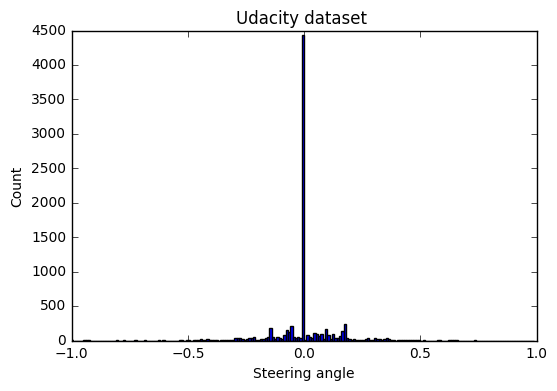

In [119]:
df = read_csv('data/driving_log.csv')
bins = np.arange(-1,1,.01)
plt.hist(df.steering,bins=bins)
plt.xlabel("Steering angle")
plt.ylabel("Count")
plt.title("Udacity dataset ")
plt.show()

In [25]:
def augment_brightness(image):
    image1 = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    random_bright = .25 + np.random.uniform()
    image1[:, :, 2] = image1[:, :, 2] * random_bright
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2BGR)
    return image1


def random_translate(image, steeringAngle):
    rows, cols, _ = image.shape
    transRange = 100
    numPixels = 10
    valPixels = 0.4
    transX = transRange * np.random.uniform() - transRange / 2
    steeringAngle = steeringAngle + transX / transRange * 2 * valPixels
    transY = numPixels * np.random.uniform() - numPixels / 2
    transMat = np.float32([[1, 0, transX], [0, 1, transY]])
    image = cv2.warpAffine(image, transMat, (cols, rows))
    return image, steeringAngle


def flip_image(img):
    return cv2.flip(img, 1)


def crop_image(image):
    # crop & scale
    return cv2.resize(image[50:140, :, :], (200, 66))

def trans_image(image,steer,trans_range):
    rows, cols, _ = image.shape
    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 10*np.random.uniform()-10/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang,tr_x

def preprocess_image(image,angle,augment=False):
    # blur
#     img = cv2.GaussianBlur(img, (3, 3), 0)
    if augment:
        image,angle,_ = trans_image(image,angle,125)
    
    img = crop_image(image)
    if augment:
        img = augment_brightness(img)
    
    # format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    return img,angle

In [107]:
def load_dataset():
    paths = []
    paths.append('./data/driving_log.csv')
    paths.append('./data/sharp_turn.csv')
    paths.append('./data/curves_driving_log.csv')
    paths.append('./data/long_drive.csv')
    data = None
    for path in paths:
        
        df = read_csv(path)
        print(path, len(df))
        if data is None:
            data = df
        else:
            
            data = pandas.concat([data,df],ignore_index=True)
    
    correction = 0.25
    data['left_steer'] = data.steering + correction
    data['right_steer'] = data.steering - correction
    data.center = "./data/" + data.center.str.strip()
    data.left = "./data/" + data.left.str.strip()
    data.right = "./data/" + data.right.str.strip()
    return data



In [100]:
def balance(data):
    balanced = pandas.DataFrame()   # Balanced dataset
    bins = 1000                 # N of bins
    bin_n = 200                 # N of examples to include in each bin (at most)

    start = 0
    for end in np.linspace(0, 1, num=bins):  
        df_range = data[(np.absolute(data.steering) >= start) & (np.absolute(data.steering) < end)]
        range_n = min(bin_n, df_range.shape[0])
        if range_n != 0:
            balanced = pd.concat([balanced, df_range.sample(range_n)])
        start = end
    return balanced


./data/driving_log.csv 8036
./data/sharp_turn.csv 738
./data/curves_driving_log.csv 1604
./data/long_drive.csv 13393
6345


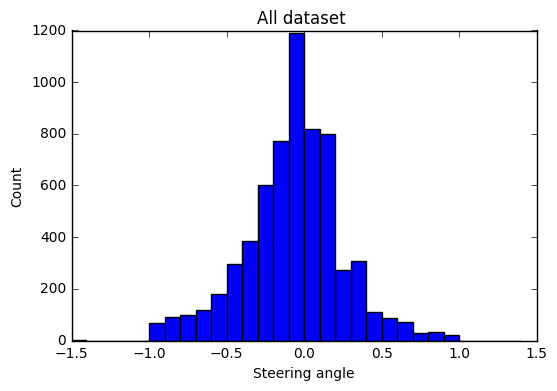

In [124]:
data  = load_dataset()
data.columns
data = balance(data)
# data = data[data.steering != 0]
data = data[data.throttle != .25]

data = data.reset_index()
print(len(data))
bins = np.arange(-1.5,1.5,.1)
plt.hist(data.steering,bins=bins)
plt.xlabel("Steering angle")
plt.ylabel("Count")
plt.title("All dataset ")
plt.show()


In [35]:
def generate_samples(data, augment=True, batch_size = 128):
    
    cameras      = {0:"center",1:"left",2:"right"}
    steer_angles = {0:"steering",1:"left_steer",2:"right_steer"}
    while True:
        # Generate random batch of indices
        indices = np.random.permutation(data.count()[0])
        
        
        for batch in range(0, len(indices), batch_size):
            batch_indices = indices[batch:(batch + batch_size)]
            # Output arrays
            x = []
            y = []
            # Read in and preprocess a batch of images
            for i in batch_indices:
                # Randomly select camera
                camera_idx = 0 
                if augment:
                    camera_idx = np.random.randint(3)
                    
                    
                # Read frame image and work out steering angle
                angle = data[steer_angles[camera_idx]][i]
                
                if(np.abs(angle) > 1.0):
                    camera_idx = 0
                    angle = data[steer_angles[camera_idx]][i]
                    
                image = cv2.imread(data[cameras[camera_idx]][i])
                
                if augment:
                    # toss a coin for train set
                    image,angle = preprocess_image(image,angle,augment=np.random.randint(2) == 0)
                else:
                    image,angle = preprocess_image(image,angle,augment=False)
                    
                   
                # Append to batch
                x.append(image)
                y.append(angle)
            
            # Randomly flip half of images in the batch
            for i in range(len(x)):
                if np.random.randint(2) == 0 and augment:
                    x[i] = flip_image(x[i])
                    y[i] = y[i] * -1

            yield (np.asarray(x), np.asarray(y))

## Dataset with augmentation

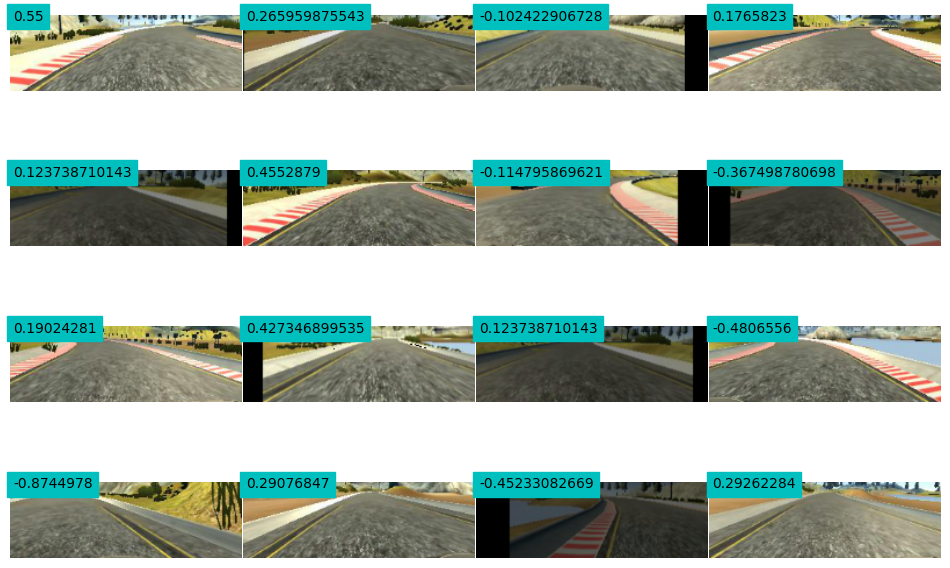

In [126]:
gen = generate_samples(data,augment=True)
bx,by = next(gen)
diaply_images(4,4,bx,by)

## Dataset without augmentation

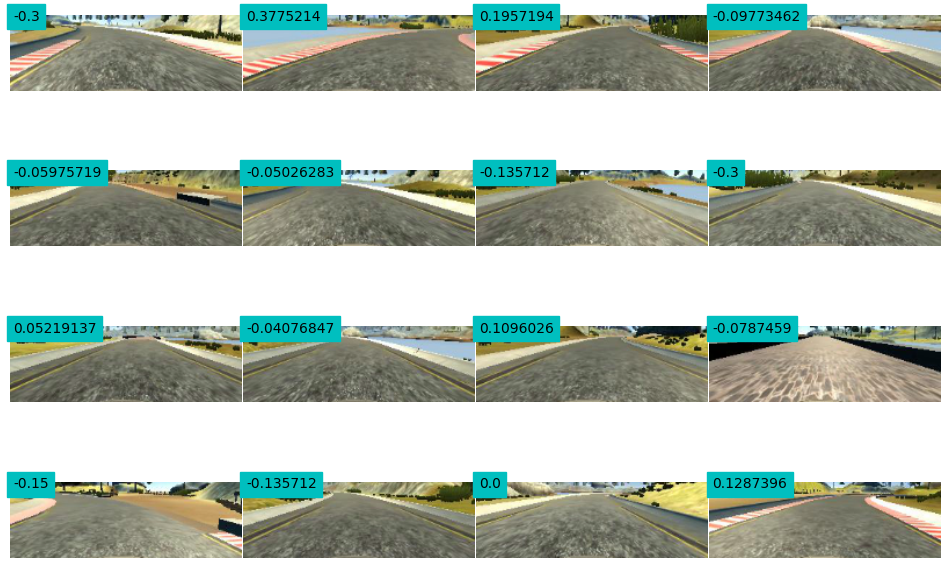

In [127]:
gen = generate_samples(data,augment=False)
bx,by = next(gen)
diaply_images(4,4,bx,by)

uint8


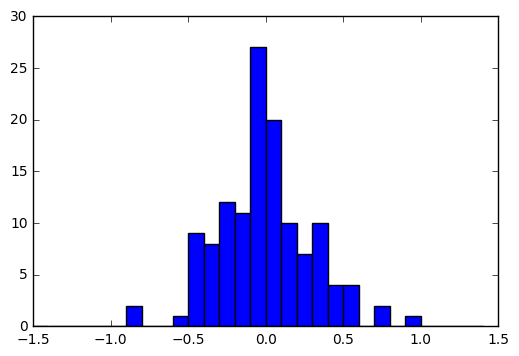

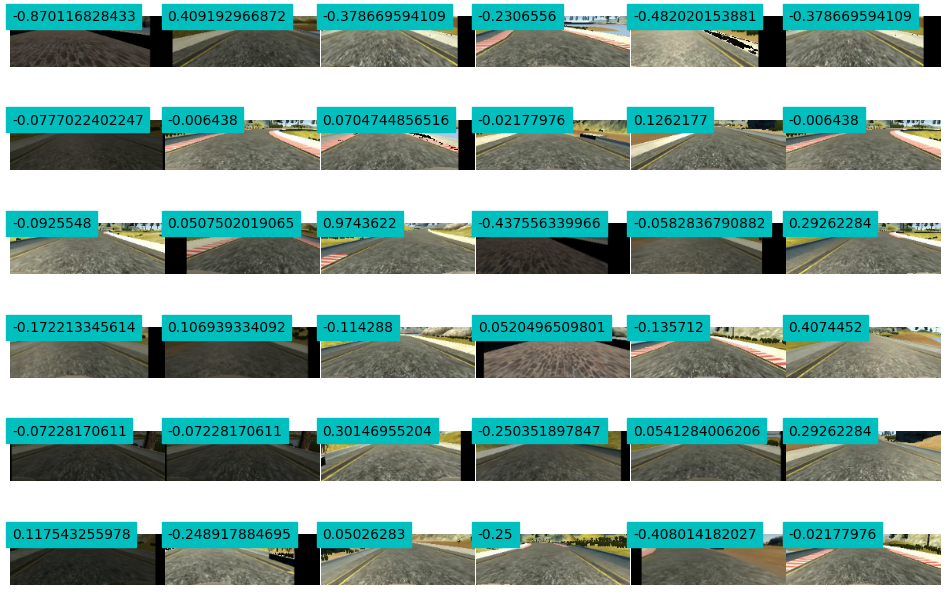

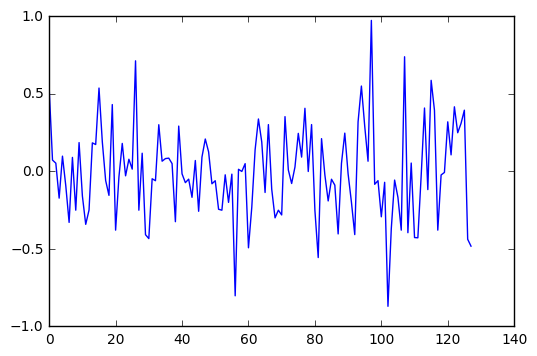

In [106]:
bx,by = next(gen)
print(bx[0].dtype)
bins = np.arange(-1.5,1.5,.1)
plt.hist(by,bins=bins)
plt.show()
diaply_images(6,6,bx,by)
plt.plot(by)